In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
import seaborn as sns
from numpy.random import uniform
from numpy.linalg import norm
from scipy.stats import mode

# Exercício 1

Este exercício se refere à classificação do gênero do locutor a partir de trechos de voz.

In [3]:
dados_voz = pd.read_csv('dados_voz_genero.csv')

Obtendo informações com relação aos dados

In [4]:
#Knowing the data
dados_voz.head()

,Unnamed: 0,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,1.0
1,1,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,1.0
2,2,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,1.0
3,3,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,1.0
4,4,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,1.0


In [5]:
dados_voz.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3168 entries, 0 to 3167
Data columns (total 21 columns):
Unnamed: 0    3168 non-null int64
sd            3168 non-null float64
median        3168 non-null float64
Q25           3168 non-null float64
Q75           3168 non-null float64
IQR           3168 non-null float64
skew          3168 non-null float64
kurt          3168 non-null float64
sp.ent        3168 non-null float64
sfm           3168 non-null float64
mode          3168 non-null float64
centroid      3168 non-null float64
meanfun       3168 non-null float64
minfun        3168 non-null float64
maxfun        3168 non-null float64
meandom       3168 non-null float64
mindom        3168 non-null float64
maxdom        3168 non-null float64
dfrange       3168 non-null float64
modindx       3168 non-null float64
label         3168 non-null float64
dtypes: float64(20), int64(1)
memory usage: 519.8 KB


## Analisando os Dados

Neste ponto temos que nenhum dos 19 atributos possui dados ausentes. É importante citar que a última coluna "label", o valor 1 corresponde ao gênero masculino e 0 ao feminino.

/usr/local/lib/python3.5/dist-packages/pandas/core/computation/check.py:19: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.6.1

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


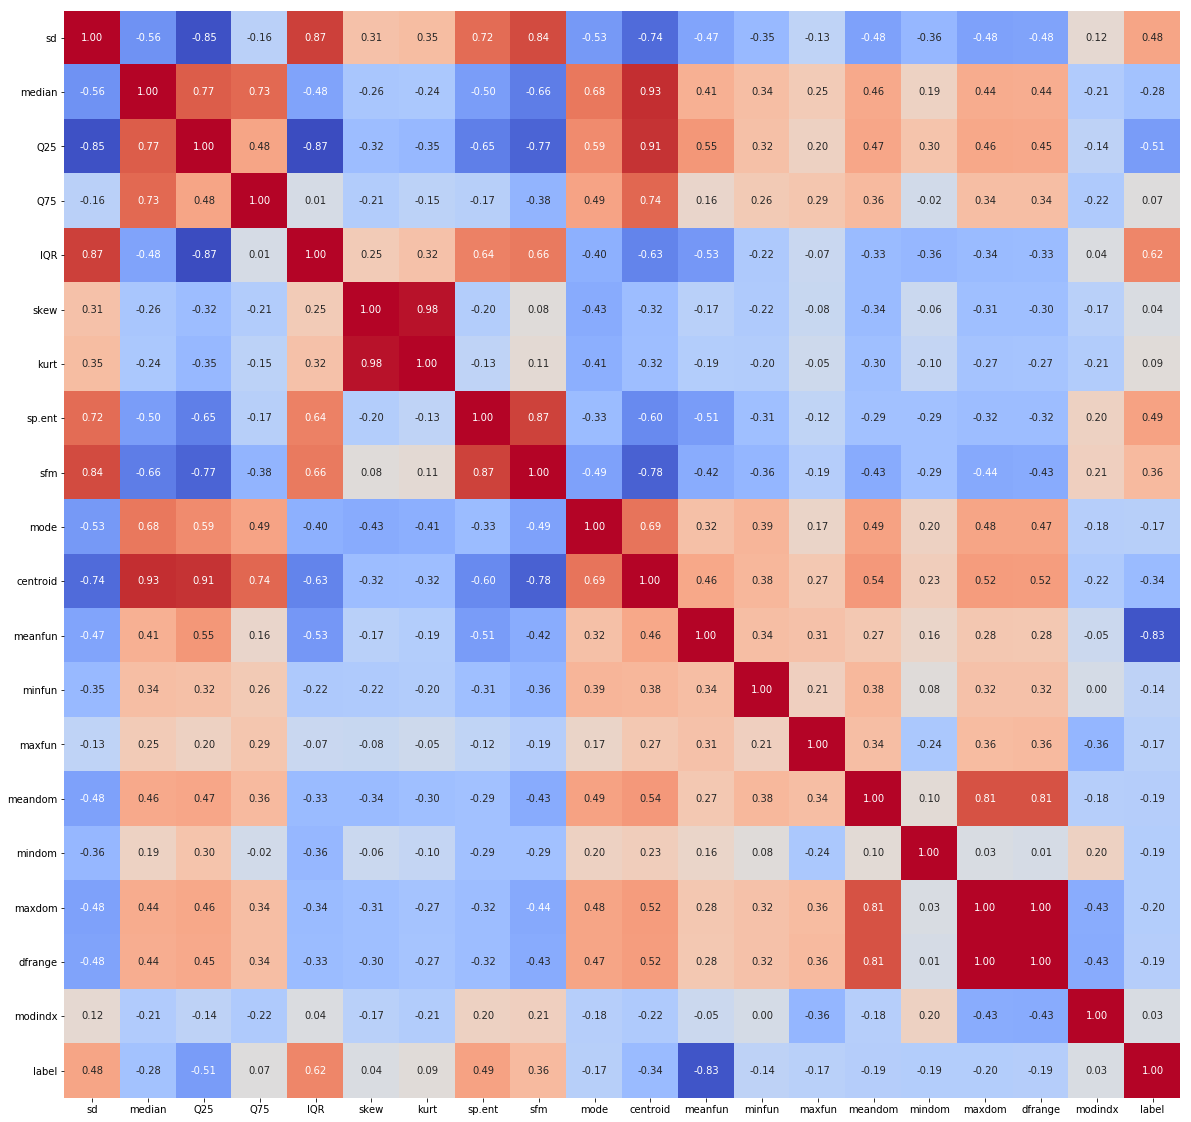

In [6]:
#Remove the unnamed collumn 
dados_voz = dados_voz.drop(['Unnamed: 0'], axis=1)
#dados_voz.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(dados_voz.corr(method='pearson'), annot=True, fmt='.2f', cmap=plt.get_cmap('coolwarm'), cbar=False, ax=ax)
ax.set_yticklabels(ax.get_yticklabels(), rotation="horizontal")
plt.savefig('Correlacao.png', pad_inches=0.0)

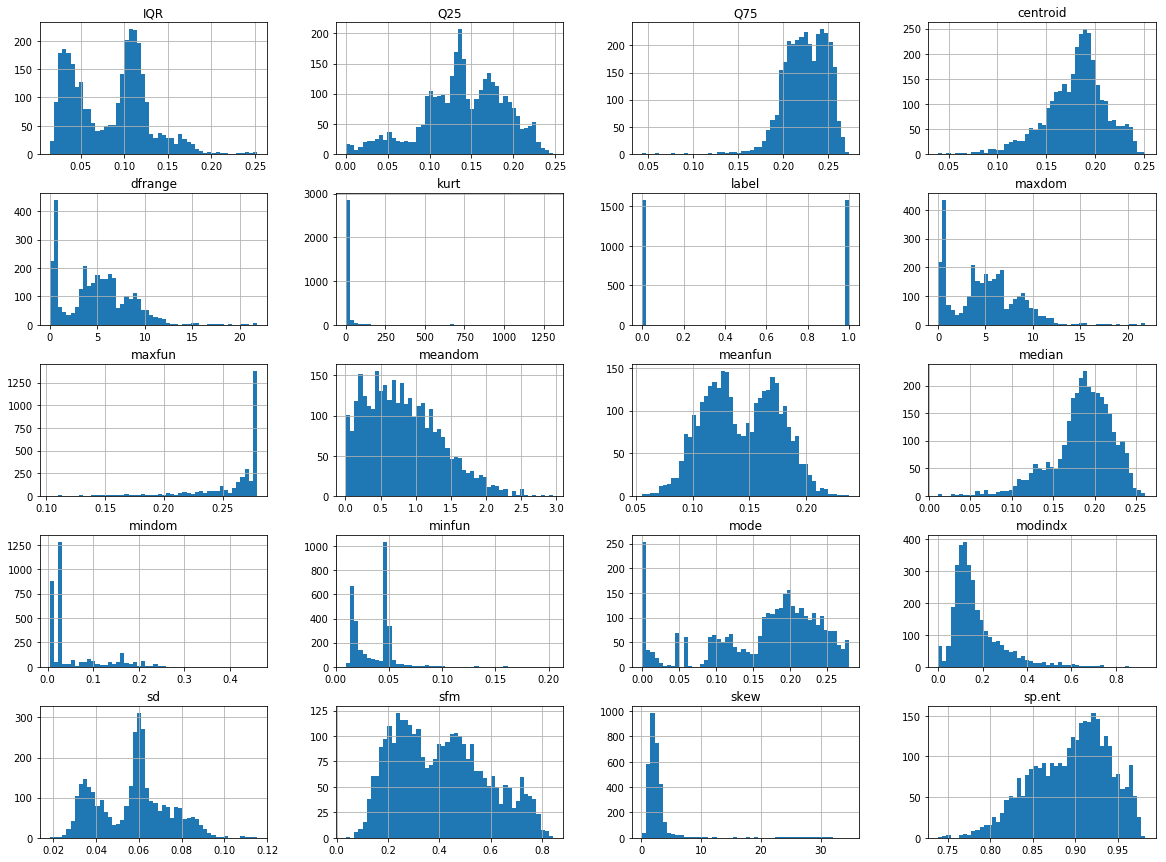

In [7]:
dados_voz.hist(bins=50, figsize=(20, 15))
plt.savefig('Histogram.png')

Aqui vamos separar 20% dos dados como conjunto de teste

In [8]:
#Creating the test and training data
X_train, X_test, Y_train, Y_test = train_test_split(dados_voz.loc[:, 'sd':'modindx'], dados_voz.loc[:, 'label'], 
                                                    test_size=0.2, random_state=42)
#X_train, X_test, Y_train, Y_test = dados_voz.loc[0:2533, 'sd':'modindx'], dados_voz.loc[2534:, 'sd':'modindx'], dados_voz.loc[0:2533, 'label'], dados_voz.loc[2534:, 'label']
#
#Y_train.shape

In [9]:
def sigmoid(phi, W):
    z = np.matmul(phi, W)

    return 1/(1 + np.exp(-z))

#This function returns the value and the gradient of the logistic regression cost function 
#for some given parameters
def logistic_regression_cost_function(phi, y, w):
    y_est = sigmoid(phi, w)
    
    J = -np.mean(y*np.log(y_est) + (1-y)*np.log(1-y_est))
    J_grad = -(np.matmul((y-y_est).T, phi))/y.shape[0]

    return J, J_grad

def gradient_descent(phi, y, lr, iter_max, tol):
    iterations = 0
    del_J = 1e9
    k = phi.shape[1]
    w = np.zeros(k)
    J_old = 0
    J_list = []
    
    while del_J > tol and iterations < iter_max:
        J_new, J_grad = logistic_regression_cost_function(phi, y, w)
        J_list.append(J_new)
        w = w - lr*J_grad

        del_J = np.absolute(J_new - J_old)
        J_old = J_new
        
        iterations += 1
        print("\nIteration: " + str(iterations) + "\nCost Function: " + str(J_new))
        
    print('Optimization is Over!')
    print('Number of Iterations: ', iterations)
    print('Cost Function Variation: ', del_J)
    
    return w, J_list

É possível ver por meio dos histogramas que os atributos possuem diferentes faixas de valores. Assim, para facilitar o processo de otimização, faz-se a normalização dos dados.

In [10]:
#Adding ones to allow the w0 optimization
X_train = np.concatenate((np.ones((X_train.shape[0], 1)), X_train), axis=1)
X_test = np.concatenate((np.ones((X_test.shape[0], 1)), X_test), axis=1)

X_train_norm = np.copy(X_train)
X_test_norm = np.copy(X_test)

scaler_binary = MinMaxScaler()

#X_train_norm[:, 1:] = normalize(X_train[:, 1:].T).T
#X_test_norm[:, 1:] = normalize(X_test[:, 1:].T).T

X_train_norm[:, 1:] = scaler_binary.fit_transform(X_train[:, 1:])
X_test_norm[:, 1:] = scaler_binary.fit_transform(X_test[:, 1:])

Y_train = Y_train.to_numpy()
Y_test = Y_test.to_numpy()

Agora vamos realizar o treinamento para a obtenção dos vetores W.

In [11]:
np.max(X_test_norm[:, 10])

1.0

In [12]:
#Training the model
w, J_iteration = gradient_descent(X_train_norm, Y_train, 1, 3000, 1e-6)

#Obtaining the predicted values
y_est_prob_val = sigmoid(X_test_norm, w)

f1_validation = []
#Obtaining the F1-Curve
threshold_values = np.arange(0, 1.001, 0.01)
for threshold in threshold_values:
    y_est_val = y_est_prob_val > threshold
    y_est_val = y_est_val.astype(int) #Convert the boolean to integer

    f1_validation.append(f1_score(Y_test, y_est_val))  


Iteration: 1
Cost Function: 0.6931471805599454

Iteration: 2
Cost Function: 0.6749674120047704

Iteration: 3
Cost Function: 0.6589067040328832

Iteration: 4
Cost Function: 0.6443515038653655

Iteration: 5
Cost Function: 0.6310789873686278

Iteration: 6
Cost Function: 0.618931973007115

Iteration: 7
Cost Function: 0.6077768943763833

Iteration: 8
Cost Function: 0.5974971940647489

Iteration: 9
Cost Function: 0.5879910302520538

Iteration: 10
Cost Function: 0.5791695397134442

Iteration: 11
Cost Function: 0.5709552570735664

Iteration: 12
Cost Function: 0.563280670854461

Iteration: 13
Cost Function: 0.5560869255060708

Iteration: 14
Cost Function: 0.549322671083958

Iteration: 15
Cost Function: 0.542943054240349

Iteration: 16
Cost Function: 0.5369088398036034

Iteration: 17
Cost Function: 0.531185650079156

Iteration: 18
Cost Function: 0.5257433084957613

Iteration: 19
Cost Function: 0.520555274626094

Iteration: 20
Cost Function: 0.5155981585380884

Iteration: 21
Cost Function: 0.510


Iteration: 259
Cost Function: 0.22625503988621076

Iteration: 260
Cost Function: 0.22586777042874054

Iteration: 261
Cost Function: 0.22548263440842903

Iteration: 262
Cost Function: 0.22509961431558065

Iteration: 263
Cost Function: 0.22471869283239598

Iteration: 264
Cost Function: 0.22433985283032634

Iteration: 265
Cost Function: 0.22396307736747295

Iteration: 266
Cost Function: 0.22358834968602903

Iteration: 267
Cost Function: 0.22321565320976355

Iteration: 268
Cost Function: 0.22284497154154753

Iteration: 269
Cost Function: 0.22247628846092002

Iteration: 270
Cost Function: 0.22210958792169447

Iteration: 271
Cost Function: 0.2217448540496042

Iteration: 272
Cost Function: 0.22138207113998593

Iteration: 273
Cost Function: 0.22102122365550125

Iteration: 274
Cost Function: 0.22066229622389513

Iteration: 275
Cost Function: 0.2203052736357902

Iteration: 276
Cost Function: 0.21995014084251702

Iteration: 277
Cost Function: 0.21959688295397908

Iteration: 278
Cost Function: 0.

Cost Function: 0.18285683713510045

Iteration: 422
Cost Function: 0.1826725674933248

Iteration: 423
Cost Function: 0.18248900419362205

Iteration: 424
Cost Function: 0.18230614321197405

Iteration: 425
Cost Function: 0.18212398055472137

Iteration: 426
Cost Function: 0.1819425122582778

Iteration: 427
Cost Function: 0.18176173438884813

Iteration: 428
Cost Function: 0.18158164304214944

Iteration: 429
Cost Function: 0.18140223434313496

Iteration: 430
Cost Function: 0.18122350444572155

Iteration: 431
Cost Function: 0.1810454495325199

Iteration: 432
Cost Function: 0.18086806581456777

Iteration: 433
Cost Function: 0.18069134953106658

Iteration: 434
Cost Function: 0.18051529694912044

Iteration: 435
Cost Function: 0.1803399043634783

Iteration: 436
Cost Function: 0.18016516809627897

Iteration: 437
Cost Function: 0.17999108449679913

Iteration: 438
Cost Function: 0.1798176499412036

Iteration: 439
Cost Function: 0.1796448608322991

Iteration: 440
Cost Function: 0.17947271359929004

I

Cost Function: 0.15659497936446154

Iteration: 618
Cost Function: 0.15649793651292151

Iteration: 619
Cost Function: 0.15640116543291105

Iteration: 620
Cost Function: 0.15630466499010318

Iteration: 621
Cost Function: 0.15620843405645063

Iteration: 622
Cost Function: 0.15611247151014243

Iteration: 623
Cost Function: 0.15601677623556126

Iteration: 624
Cost Function: 0.15592134712324074

Iteration: 625
Cost Function: 0.1558261830698235

Iteration: 626
Cost Function: 0.15573128297801916

Iteration: 627
Cost Function: 0.1556366457565631

Iteration: 628
Cost Function: 0.15554227032017517

Iteration: 629
Cost Function: 0.15544815558951894

Iteration: 630
Cost Function: 0.15535430049116122

Iteration: 631
Cost Function: 0.15526070395753216

Iteration: 632
Cost Function: 0.155167364926885

Iteration: 633
Cost Function: 0.15507428234325707

Iteration: 634
Cost Function: 0.15498145515643028

Iteration: 635
Cost Function: 0.15488888232189243

Iteration: 636
Cost Function: 0.15479656280079884



Iteration: 792
Cost Function: 0.1429461321795895

Iteration: 793
Cost Function: 0.14288362171322214

Iteration: 794
Cost Function: 0.14282125225075354

Iteration: 795
Cost Function: 0.1427590233179236

Iteration: 796
Cost Function: 0.14269693444259346

Iteration: 797
Cost Function: 0.14263498515473405

Iteration: 798
Cost Function: 0.14257317498641425

Iteration: 799
Cost Function: 0.14251150347178912

Iteration: 800
Cost Function: 0.1424499701470884

Iteration: 801
Cost Function: 0.14238857455060502

Iteration: 802
Cost Function: 0.1423273162226837

Iteration: 803
Cost Function: 0.14226619470570948

Iteration: 804
Cost Function: 0.14220520954409657

Iteration: 805
Cost Function: 0.1421443602842771

Iteration: 806
Cost Function: 0.14208364647469002

Iteration: 807
Cost Function: 0.14202306766576983

Iteration: 808
Cost Function: 0.14196262340993607

Iteration: 809
Cost Function: 0.1419023132615819

Iteration: 810
Cost Function: 0.1418421367770636

Iteration: 811
Cost Function: 0.14178


Iteration: 957
Cost Function: 0.13424458952093243

Iteration: 958
Cost Function: 0.1342001981765842

Iteration: 959
Cost Function: 0.134155891470604

Iteration: 960
Cost Function: 0.13411166916266226

Iteration: 961
Cost Function: 0.13406753101333863

Iteration: 962
Cost Function: 0.13402347678411744

Iteration: 963
Cost Function: 0.1339795062373836

Iteration: 964
Cost Function: 0.13393561913641822

Iteration: 965
Cost Function: 0.13389181524539448

Iteration: 966
Cost Function: 0.13384809432937342

Iteration: 967
Cost Function: 0.1338044561542998

Iteration: 968
Cost Function: 0.13376090048699785

Iteration: 969
Cost Function: 0.13371742709516724

Iteration: 970
Cost Function: 0.13367403574737896

Iteration: 971
Cost Function: 0.13363072621307132

Iteration: 972
Cost Function: 0.13358749826254573

Iteration: 973
Cost Function: 0.13354435166696274

Iteration: 974
Cost Function: 0.1335012861983381

Iteration: 975
Cost Function: 0.1334583016295387

Iteration: 976
Cost Function: 0.13341


Iteration: 1142
Cost Function: 0.1272598930548797

Iteration: 1143
Cost Function: 0.1272278451595741

Iteration: 1144
Cost Function: 0.12719584938300924

Iteration: 1145
Cost Function: 0.12716390559928048

Iteration: 1146
Cost Function: 0.1271320136828887

Iteration: 1147
Cost Function: 0.1271001735087387

Iteration: 1148
Cost Function: 0.12706838495213751

Iteration: 1149
Cost Function: 0.12703664788879276

Iteration: 1150
Cost Function: 0.12700496219481108

Iteration: 1151
Cost Function: 0.12697332774669665

Iteration: 1152
Cost Function: 0.12694174442134928

Iteration: 1153
Cost Function: 0.1269102120960632

Iteration: 1154
Cost Function: 0.1268787306485252

Iteration: 1155
Cost Function: 0.1268472999568132

Iteration: 1156
Cost Function: 0.12681591989939467

Iteration: 1157
Cost Function: 0.1267845903551251

Iteration: 1158
Cost Function: 0.1267533112032463

Iteration: 1159
Cost Function: 0.126722082323385

Iteration: 1160
Cost Function: 0.1266909035955514

Iteration: 1161
Cost Fu


Iteration: 1321
Cost Function: 0.1222499807499812

Iteration: 1322
Cost Function: 0.1222255797796301

Iteration: 1323
Cost Function: 0.12220121358913111

Iteration: 1324
Cost Function: 0.12217688210507828

Iteration: 1325
Cost Function: 0.12215258525427224

Iteration: 1326
Cost Function: 0.12212832296371949

Iteration: 1327
Cost Function: 0.12210409516063164

Iteration: 1328
Cost Function: 0.12207990177242466

Iteration: 1329
Cost Function: 0.12205574272671826

Iteration: 1330
Cost Function: 0.12203161795133512

Iteration: 1331
Cost Function: 0.12200752737430008

Iteration: 1332
Cost Function: 0.12198347092383971

Iteration: 1333
Cost Function: 0.12195944852838132

Iteration: 1334
Cost Function: 0.12193546011655228

Iteration: 1335
Cost Function: 0.1219115056171795

Iteration: 1336
Cost Function: 0.12188758495928873

Iteration: 1337
Cost Function: 0.1218636980721036

Iteration: 1338
Cost Function: 0.1218398448850451

Iteration: 1339
Cost Function: 0.12181602532773106

Iteration: 1340



Iteration: 1541
Cost Function: 0.11760814174809421

Iteration: 1542
Cost Function: 0.11758992728190713

Iteration: 1543
Cost Function: 0.11757173539015695

Iteration: 1544
Cost Function: 0.11755356603159454

Iteration: 1545
Cost Function: 0.11753541916507144

Iteration: 1546
Cost Function: 0.11751729474953919

Iteration: 1547
Cost Function: 0.11749919274404919

Iteration: 1548
Cost Function: 0.11748111310775237

Iteration: 1549
Cost Function: 0.11746305579989905

Iteration: 1550
Cost Function: 0.11744502077983822

Iteration: 1551
Cost Function: 0.11742700800701769

Iteration: 1552
Cost Function: 0.11740901744098355

Iteration: 1553
Cost Function: 0.1173910490413799

Iteration: 1554
Cost Function: 0.11737310276794859

Iteration: 1555
Cost Function: 0.11735517858052892

Iteration: 1556
Cost Function: 0.11733727643905734

Iteration: 1557
Cost Function: 0.11731939630356711

Iteration: 1558
Cost Function: 0.11730153813418814

Iteration: 1559
Cost Function: 0.1172837018911465

Iteration: 15


Iteration: 1782
Cost Function: 0.1137883042575786

Iteration: 1783
Cost Function: 0.11377453301990076

Iteration: 1784
Cost Function: 0.11376077674309067

Iteration: 1785
Cost Function: 0.11374703540330655

Iteration: 1786
Cost Function: 0.11373330897675714

Iteration: 1787
Cost Function: 0.11371959743970167

Iteration: 1788
Cost Function: 0.11370590076844969

Iteration: 1789
Cost Function: 0.1136922189393609

Iteration: 1790
Cost Function: 0.1136785519288452

Iteration: 1791
Cost Function: 0.1136648997133622

Iteration: 1792
Cost Function: 0.11365126226942146

Iteration: 1793
Cost Function: 0.11363763957358215

Iteration: 1794
Cost Function: 0.11362403160245294

Iteration: 1795
Cost Function: 0.11361043833269192

Iteration: 1796
Cost Function: 0.1135968597410065

Iteration: 1797
Cost Function: 0.1135832958041531

Iteration: 1798
Cost Function: 0.11356974649893735

Iteration: 1799
Cost Function: 0.11355621180221351

Iteration: 1800
Cost Function: 0.11354269169088481

Iteration: 1801
C


Iteration: 2008
Cost Function: 0.1110159129405525

Iteration: 2009
Cost Function: 0.11100500027884598

Iteration: 2010
Cost Function: 0.11099409825994205

Iteration: 2011
Cost Function: 0.11098320686868937

Iteration: 2012
Cost Function: 0.11097232608996518

Iteration: 2013
Cost Function: 0.11096145590867547

Iteration: 2014
Cost Function: 0.1109505963097546

Iteration: 2015
Cost Function: 0.11093974727816563

Iteration: 2016
Cost Function: 0.11092890879889987

Iteration: 2017
Cost Function: 0.11091808085697713

Iteration: 2018
Cost Function: 0.11090726343744538

Iteration: 2019
Cost Function: 0.11089645652538088

Iteration: 2020
Cost Function: 0.110885660105888

Iteration: 2021
Cost Function: 0.1108748741640993

Iteration: 2022
Cost Function: 0.11086409868517523

Iteration: 2023
Cost Function: 0.11085333365430422

Iteration: 2024
Cost Function: 0.11084257905670267

Iteration: 2025
Cost Function: 0.11083183487761472

Iteration: 2026
Cost Function: 0.1108211011023123

Iteration: 2027
C

Cost Function: 0.10871490936012347

Iteration: 2244
Cost Function: 0.10870613500338593

Iteration: 2245
Cost Function: 0.10869736839337796

Iteration: 2246
Cost Function: 0.10868860952016758

Iteration: 2247
Cost Function: 0.10867985837383973

Iteration: 2248
Cost Function: 0.10867111494449619

Iteration: 2249
Cost Function: 0.10866237922225574

Iteration: 2250
Cost Function: 0.10865365119725377

Iteration: 2251
Cost Function: 0.10864493085964262

Iteration: 2252
Cost Function: 0.10863621819959121

Iteration: 2253
Cost Function: 0.10862751320728528

Iteration: 2254
Cost Function: 0.1086188158729272

Iteration: 2255
Cost Function: 0.10861012618673596

Iteration: 2256
Cost Function: 0.10860144413894719

Iteration: 2257
Cost Function: 0.10859276971981302

Iteration: 2258
Cost Function: 0.10858410291960212

Iteration: 2259
Cost Function: 0.10857544372859973

Iteration: 2260
Cost Function: 0.10856679213710743

Iteration: 2261
Cost Function: 0.10855814813544334

Iteration: 2262
Cost Function

Cost Function: 0.10668260781253357

Iteration: 2502
Cost Function: 0.10667554495131853

Iteration: 2503
Cost Function: 0.10666848774775836

Iteration: 2504
Cost Function: 0.10666143619530992

Iteration: 2505
Cost Function: 0.10665439028744007

Iteration: 2506
Cost Function: 0.1066473500176258

Iteration: 2507
Cost Function: 0.10664031537935408

Iteration: 2508
Cost Function: 0.1066332863661218

Iteration: 2509
Cost Function: 0.10662626297143579

Iteration: 2510
Cost Function: 0.10661924518881298

Iteration: 2511
Cost Function: 0.10661223301178012

Iteration: 2512
Cost Function: 0.1066052264338738

Iteration: 2513
Cost Function: 0.10659822544864067

Iteration: 2514
Cost Function: 0.10659123004963707

Iteration: 2515
Cost Function: 0.10658424023042933

Iteration: 2516
Cost Function: 0.10657725598459354

Iteration: 2517
Cost Function: 0.10657027730571556

Iteration: 2518
Cost Function: 0.10656330418739116

Iteration: 2519
Cost Function: 0.10655633662322582

Iteration: 2520
Cost Function: 


Iteration: 2758
Cost Function: 0.10503689609077153

Iteration: 2759
Cost Function: 0.10503109701807696

Iteration: 2760
Cost Function: 0.10502530220483096

Iteration: 2761
Cost Function: 0.10501951164654309

Iteration: 2762
Cost Function: 0.10501372533872917

Iteration: 2763
Cost Function: 0.10500794327691129

Iteration: 2764
Cost Function: 0.10500216545661782

Iteration: 2765
Cost Function: 0.10499639187338328

Iteration: 2766
Cost Function: 0.10499062252274854

Iteration: 2767
Cost Function: 0.10498485740026059

Iteration: 2768
Cost Function: 0.1049790965014727

Iteration: 2769
Cost Function: 0.10497333982194423

Iteration: 2770
Cost Function: 0.10496758735724088

Iteration: 2771
Cost Function: 0.1049618391029344

Iteration: 2772
Cost Function: 0.10495609505460277

Iteration: 2773
Cost Function: 0.10495035520783004

Iteration: 2774
Cost Function: 0.10494461955820651

Iteration: 2775
Cost Function: 0.10493888810132854

Iteration: 2776
Cost Function: 0.10493316083279866

Iteration: 27

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold que maximiza F1: 0.51
F1 Máximo: 0.9836552748885588


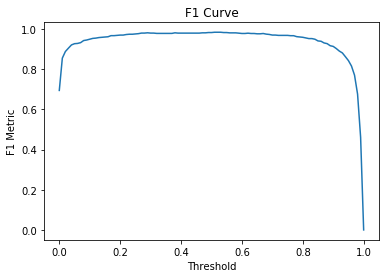

In [13]:
plt.plot(threshold_values, f1_validation)
plt.xlabel('Threshold')
plt.ylabel('F1 Metric')
plt.title('F1 Curve')
plt.savefig('F1_Curve_Binary.png')

threshold_max = f1_validation.index(np.max(f1_validation))/100
print("Threshold que maximiza F1: " + str(threshold_max))
print("F1 Máximo: " + str(np.max(f1_validation)))

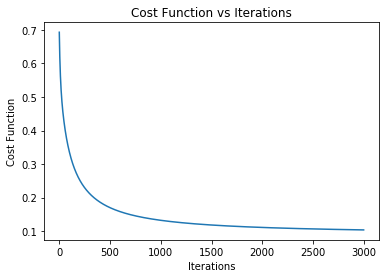

In [14]:
plt.plot(J_iteration)
plt.xlabel('Iterations')
plt.ylabel('Cost Function')
plt.title('Cost Function vs Iterations')
plt.savefig('Cost_Function_Binary.png')

In [15]:
fp, tp, _ = roc_curve(Y_test, y_est_prob_val)
area = auc(fp, tp)

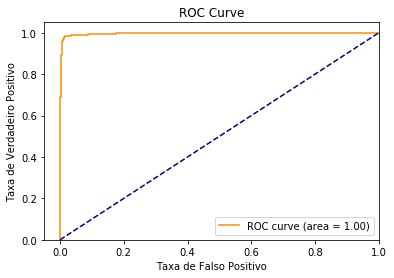

In [16]:
plt.plot(fp, tp, color='darkorange', label='ROC curve (area = %0.2f)' % area)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.legend(loc="lower right")
plt.title('ROC Curve')
plt.savefig('ROC_Curve_Binary.png')

Calculando a Matriz de confusão para o menor threshold que foi de 0.11

Accuracy: 0.9826498422712934


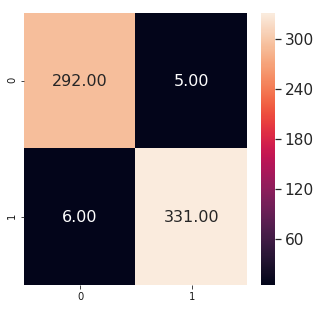

In [17]:
y_est_val = y_est_prob_val > threshold_max
y_est_val = y_est_val.astype(int) #Convert the boolean to integer

cm = confusion_matrix(Y_test, y_est_val)

fig, ax = plt.subplots(figsize=(5, 5))
df_cm = pd.DataFrame(cm, range(2), range(2))
#plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='.2f', ax=ax)# font size
plt.savefig('Confusion_matrix_Binary.png')

sns.reset_orig()

accuracy = accuracy_score(Y_test, y_est_val)
print("Accuracy: " + str(accuracy))

# Exercício 2

Este exercício realiza a classificação multi-classe utilizando os algoritmos de regressão logística e k-Nearest Neighbours. 
A base de dados utilizada corresponde aos atributos nos domínios do tempo e da frequência extraídos de sinais de acelerômetro e giroscópio de um smartphone.

Os rótulos correspondem a: 
0 - Caminhada
1 - Subindo escadas
2 - Descendo escadas
3 - Sentado
4 - Em pé
5 - Deitado

In [18]:
X_train = pd.read_fwf('/home/felippe/Área de Trabalho/Felippe/Mestrado/Machine_Learning/IA006/Exercicio_2/har_smartphone/X_train.txt').to_numpy()
X_test = pd.read_fwf('/home/felippe/Área de Trabalho/Felippe/Mestrado/Machine_Learning/IA006/Exercicio_2/har_smartphone/X_test.txt').to_numpy()

Y_train = pd.read_fwf('/home/felippe/Área de Trabalho/Felippe/Mestrado/Machine_Learning/IA006/Exercicio_2/har_smartphone/y_train.txt').to_numpy()
Y_test = pd.read_fwf('/home/felippe/Área de Trabalho/Felippe/Mestrado/Machine_Learning/IA006/Exercicio_2/har_smartphone/y_test.txt').to_numpy()

Agora vamos criar algumas funções para a implementação do algoritmo de regressão logística utilizando softmax.

In [19]:
def softmax_estimation(X, w):
    z = np.exp(np.matmul(X, w))
    z_sum = np.expand_dims(np.sum(z, axis=1), axis=0)
    y_est = z/z_sum.T
    
    return y_est

def convert_y_softmax(y):
    y_labels = np.unique(y)
    N = y.shape[0]
    k = y_labels.shape[0]
    y_softmax = np.zeros((N, k))
    
    
    for i in range(N):
        y_softmax[i, y[i]-1] = 1
    
    return y_softmax

def logistic_regression_multi_class_cost_function(X, w, y):
    y_est = softmax_estimation(X, w)
    y_softmax = convert_y_softmax(y)

    J = -np.mean(np.sum( y_softmax*np.log(y_est), axis=1 )) 
    J_grad = -(1/X.shape[0])*np.matmul(X.T, (y_softmax - y_est))
    
    return J, J_grad

def gradient_descent_softmax(X, y, lr, iter_max, tol):
    iterations = 0
    del_J = 1e9
    k = X.shape[1]
    w = np.zeros([k, np.unique(y).shape[0]])
    J_old = 0
    J_list = []
    
    while del_J > tol and iterations < iter_max:
        J_new, J_grad = logistic_regression_multi_class_cost_function(X, w, y)
        J_list.append(J_new)
        w = w - lr*J_grad

        del_J = np.absolute(J_new - J_old)
        J_old = J_new
        
        iterations += 1
        
        print("\nIteration: " + str(iterations) + "\nCost Function: " + str(J_new))
        
    print('Optimization is Over!')
    print('Number of Iterations: ', iterations)
    print('Cost Function Variation: ', del_J)
    
    return w, J_list

In [20]:
#Adding ones to allow the w0 optimization
X_train = np.concatenate((np.ones((X_train.shape[0], 1)), X_train), axis=1)
X_test = np.concatenate((np.ones((X_test.shape[0], 1)), X_test), axis=1)

X_train_norm = np.copy(X_train)
X_test_norm = np.copy(X_test)

scaler_multiclass = MinMaxScaler()

X_train_norm[:, 1:] = scaler_multiclass.fit_transform(X_train[:, 1:])
X_test_norm[:, 1:] = scaler_multiclass.fit_transform(X_test[:, 1:])

#X_train_norm[:, 1:] = normalize(X_train[:, 1:].T).T
#X_test_norm[:, 1:] = normalize(X_test[:, 1:].T).T

In [24]:
print(np.max(X_train[:, 20]))
print(np.min(X_train[:, 20]))

1.0
-1.0


1

In [45]:
#Training the model
w, J_iteration = gradient_descent_softmax(X_train_norm, Y_train, 0.18, 6000, 1e-6)


Iteration: 1
Cost Function: 1.7917594692280547

Iteration: 2
Cost Function: 1.5602462106311388

Iteration: 3
Cost Function: 1.4149359323166726

Iteration: 4
Cost Function: 1.3146804554600138

Iteration: 5
Cost Function: 1.2405197205421925

Iteration: 6
Cost Function: 1.1817108529941787

Iteration: 7
Cost Function: 1.1340193885786582

Iteration: 8
Cost Function: 1.0932521400816386

Iteration: 9
Cost Function: 1.0595113440938986

Iteration: 10
Cost Function: 1.0289583129006892

Iteration: 11
Cost Function: 1.0053070370905366

Iteration: 12
Cost Function: 0.9810908934500903

Iteration: 13
Cost Function: 0.9666542754141222

Iteration: 14
Cost Function: 0.9446961588517703

Iteration: 15
Cost Function: 0.9386496029485881

Iteration: 16
Cost Function: 0.913863678816057

Iteration: 17
Cost Function: 0.9137405126001786

Iteration: 18
Cost Function: 0.8839714679869219

Iteration: 19
Cost Function: 0.8868580266286605

Iteration: 20
Cost Function: 0.8545389284919015

Iteration: 21
Cost Function: 


Iteration: 168
Cost Function: 0.34778812870572323

Iteration: 169
Cost Function: 0.34694837888393226

Iteration: 170
Cost Function: 0.34611564546540624

Iteration: 171
Cost Function: 0.34528982718888696

Iteration: 172
Cost Function: 0.3444708248182207

Iteration: 173
Cost Function: 0.34365854109126714

Iteration: 174
Cost Function: 0.34285288067035835

Iteration: 175
Cost Function: 0.34205375009425565

Iteration: 176
Cost Function: 0.341261057731549

Iteration: 177
Cost Function: 0.3404747137354489

Iteration: 178
Cost Function: 0.3396946299999226

Iteration: 179
Cost Function: 0.33892072011712765

Iteration: 180
Cost Function: 0.33815289933609793

Iteration: 181
Cost Function: 0.3373910845226387

Iteration: 182
Cost Function: 0.3366351941203901

Iteration: 183
Cost Function: 0.3358851481130185

Iteration: 184
Cost Function: 0.33514086798749837

Iteration: 185
Cost Function: 0.33440227669844685

Iteration: 186
Cost Function: 0.3336692986334769

Iteration: 187
Cost Function: 0.3329418


Iteration: 334
Cost Function: 0.26264487422008054

Iteration: 335
Cost Function: 0.26232063036017356

Iteration: 336
Cost Function: 0.2619976974663239

Iteration: 337
Cost Function: 0.2616760661747734

Iteration: 338
Cost Function: 0.26135572721852524

Iteration: 339
Cost Function: 0.26103667142604875

Iteration: 340
Cost Function: 0.2607188897200046

Iteration: 341
Cost Function: 0.2604023731159913

Iteration: 342
Cost Function: 0.2600871127213117

Iteration: 343
Cost Function: 0.2597730997337593

Iteration: 344
Cost Function: 0.2594603254404241

Iteration: 345
Cost Function: 0.25914878121651774

Iteration: 346
Cost Function: 0.2588384585242178

Iteration: 347
Cost Function: 0.25852934891152896

Iteration: 348
Cost Function: 0.2582214440111648

Iteration: 349
Cost Function: 0.25791473553944483

Iteration: 350
Cost Function: 0.2576092152952106

Iteration: 351
Cost Function: 0.2573048751587582

Iteration: 352
Cost Function: 0.257001707090788

Iteration: 353
Cost Function: 0.25669970313


Iteration: 499
Cost Function: 0.22201320316215942

Iteration: 500
Cost Function: 0.22182449555978026

Iteration: 501
Cost Function: 0.22163629630495005

Iteration: 502
Cost Function: 0.22144860303568353

Iteration: 503
Cost Function: 0.22126141340590613

Iteration: 504
Cost Function: 0.22107472508531287

Iteration: 505
Cost Function: 0.2208885357592283

Iteration: 506
Cost Function: 0.22070284312846847

Iteration: 507
Cost Function: 0.22051764490920409

Iteration: 508
Cost Function: 0.2203329388328253

Iteration: 509
Cost Function: 0.2201487226458077

Iteration: 510
Cost Function: 0.21996499410958043

Iteration: 511
Cost Function: 0.21978175100039493

Iteration: 512
Cost Function: 0.21959899110919567

Iteration: 513
Cost Function: 0.21941671224149192

Iteration: 514
Cost Function: 0.21923491221723132

Iteration: 515
Cost Function: 0.21905358887067428

Iteration: 516
Cost Function: 0.21887274005027021

Iteration: 517
Cost Function: 0.2186923636185349

Iteration: 518
Cost Function: 0.21


Iteration: 666
Cost Function: 0.19613076308438482

Iteration: 667
Cost Function: 0.19600309176393926

Iteration: 668
Cost Function: 0.19587568106803951

Iteration: 669
Cost Function: 0.19574853009575505

Iteration: 670
Cost Function: 0.1956216379506145

Iteration: 671
Cost Function: 0.19549500374057688

Iteration: 672
Cost Function: 0.19536862657800255

Iteration: 673
Cost Function: 0.1952425055796248

Iteration: 674
Cost Function: 0.19511663986652159

Iteration: 675
Cost Function: 0.1949910285640872

Iteration: 676
Cost Function: 0.19486567080200456

Iteration: 677
Cost Function: 0.19474056571421766

Iteration: 678
Cost Function: 0.1946157124389038

Iteration: 679
Cost Function: 0.1944911101184467

Iteration: 680
Cost Function: 0.19436675789940946

Iteration: 681
Cost Function: 0.19424265493250759

Iteration: 682
Cost Function: 0.19411880037258267

Iteration: 683
Cost Function: 0.19399519337857593

Iteration: 684
Cost Function: 0.193871833113502

Iteration: 685
Cost Function: 0.19374


Iteration: 832
Cost Function: 0.17794454871617532

Iteration: 833
Cost Function: 0.17785044025510985

Iteration: 834
Cost Function: 0.17775648765281116

Iteration: 835
Cost Function: 0.17766269047646685

Iteration: 836
Cost Function: 0.1775690482949697

Iteration: 837
Cost Function: 0.17747556067890902

Iteration: 838
Cost Function: 0.17738222720056177

Iteration: 839
Cost Function: 0.17728904743388418

Iteration: 840
Cost Function: 0.17719602095450296

Iteration: 841
Cost Function: 0.17710314733970672

Iteration: 842
Cost Function: 0.1770104261684376

Iteration: 843
Cost Function: 0.17691785702128263

Iteration: 844
Cost Function: 0.1768254394804657

Iteration: 845
Cost Function: 0.17673317312983886

Iteration: 846
Cost Function: 0.17664105755487422

Iteration: 847
Cost Function: 0.1765490923426557

Iteration: 848
Cost Function: 0.17645727708187095

Iteration: 849
Cost Function: 0.1763656113628029

Iteration: 850
Cost Function: 0.1762740947773221

Iteration: 851
Cost Function: 0.1761


Iteration: 996
Cost Function: 0.16432414470533277

Iteration: 997
Cost Function: 0.16425083141328106

Iteration: 998
Cost Function: 0.16417762076658746

Iteration: 999
Cost Function: 0.16410451252564648

Iteration: 1000
Cost Function: 0.16403150645164224

Iteration: 1001
Cost Function: 0.16395860230654477

Iteration: 1002
Cost Function: 0.16388579985310728

Iteration: 1003
Cost Function: 0.16381309885486203

Iteration: 1004
Cost Function: 0.1637404990761177

Iteration: 1005
Cost Function: 0.16366800028195566

Iteration: 1006
Cost Function: 0.1635956022382268

Iteration: 1007
Cost Function: 0.16352330471154833

Iteration: 1008
Cost Function: 0.16345110746930036

Iteration: 1009
Cost Function: 0.16337901027962293

Iteration: 1010
Cost Function: 0.1633070129114125

Iteration: 1011
Cost Function: 0.16323511513431885

Iteration: 1012
Cost Function: 0.16316331671874196

Iteration: 1013
Cost Function: 0.1630916174358288

Iteration: 1014
Cost Function: 0.16302001705747027

Iteration: 1015
Cos


Iteration: 1160
Cost Function: 0.15351996558422903

Iteration: 1161
Cost Function: 0.15346076950371565

Iteration: 1162
Cost Function: 0.15340164531909314

Iteration: 1163
Cost Function: 0.15334259288532975

Iteration: 1164
Cost Function: 0.15328361205780547

Iteration: 1165
Cost Function: 0.15322470269231037

Iteration: 1166
Cost Function: 0.15316586464504342

Iteration: 1167
Cost Function: 0.15310709777261067

Iteration: 1168
Cost Function: 0.15304840193202393

Iteration: 1169
Cost Function: 0.15298977698069918

Iteration: 1170
Cost Function: 0.15293122277645513

Iteration: 1171
Cost Function: 0.15287273917751176

Iteration: 1172
Cost Function: 0.152814326042489

Iteration: 1173
Cost Function: 0.15275598323040493

Iteration: 1174
Cost Function: 0.15269771060067466

Iteration: 1175
Cost Function: 0.1526395080131086

Iteration: 1176
Cost Function: 0.15258137532791125

Iteration: 1177
Cost Function: 0.15252331240567982

Iteration: 1178
Cost Function: 0.15246531910740235

Iteration: 117


Iteration: 1320
Cost Function: 0.14487566301295243

Iteration: 1321
Cost Function: 0.14482636643184596

Iteration: 1322
Cost Function: 0.14477712291890232

Iteration: 1323
Cost Function: 0.14472793237949366

Iteration: 1324
Cost Function: 0.14467879471922904

Iteration: 1325
Cost Function: 0.14462970984395368

Iteration: 1326
Cost Function: 0.14458067765974822

Iteration: 1327
Cost Function: 0.14453169807292793

Iteration: 1328
Cost Function: 0.14448277099004195

Iteration: 1329
Cost Function: 0.14443389631787262

Iteration: 1330
Cost Function: 0.1443850739634347

Iteration: 1331
Cost Function: 0.1443363038339744

Iteration: 1332
Cost Function: 0.144287585836969

Iteration: 1333
Cost Function: 0.1442389198801258

Iteration: 1334
Cost Function: 0.14419030587138168

Iteration: 1335
Cost Function: 0.14414174371890198

Iteration: 1336
Cost Function: 0.1440932333310801

Iteration: 1337
Cost Function: 0.14404477461653656

Iteration: 1338
Cost Function: 0.14399636748411854

Iteration: 1339
C


Iteration: 1484
Cost Function: 0.1374382721222729

Iteration: 1485
Cost Function: 0.13739656517982415

Iteration: 1486
Cost Function: 0.1373548984769304

Iteration: 1487
Cost Function: 0.1373132719494177

Iteration: 1488
Cost Function: 0.13727168553325578

Iteration: 1489
Cost Function: 0.13723013916455723

Iteration: 1490
Cost Function: 0.13718863277957735

Iteration: 1491
Cost Function: 0.13714716631471358

Iteration: 1492
Cost Function: 0.13710573970650522

Iteration: 1493
Cost Function: 0.13706435289163302

Iteration: 1494
Cost Function: 0.13702300580691854

Iteration: 1495
Cost Function: 0.13698169838932406

Iteration: 1496
Cost Function: 0.136940430575952

Iteration: 1497
Cost Function: 0.13689920230404456

Iteration: 1498
Cost Function: 0.13685801351098334

Iteration: 1499
Cost Function: 0.13681686413428887

Iteration: 1500
Cost Function: 0.13677575411162024

Iteration: 1501
Cost Function: 0.1367346833807748

Iteration: 1502
Cost Function: 0.13669365187968757

Iteration: 1503
C


Iteration: 1643
Cost Function: 0.13127350806689536

Iteration: 1644
Cost Function: 0.13123747786237958

Iteration: 1645
Cost Function: 0.13120147925675588

Iteration: 1646
Cost Function: 0.13116551220428574

Iteration: 1647
Cost Function: 0.1311295766593233

Iteration: 1648
Cost Function: 0.13109367257631513

Iteration: 1649
Cost Function: 0.1310577999098

Iteration: 1650
Cost Function: 0.13102195861440855

Iteration: 1651
Cost Function: 0.13098614864486313

Iteration: 1652
Cost Function: 0.1309503699559775

Iteration: 1653
Cost Function: 0.13091462250265673

Iteration: 1654
Cost Function: 0.1308789062398968

Iteration: 1655
Cost Function: 0.13084322112278438

Iteration: 1656
Cost Function: 0.13080756710649674

Iteration: 1657
Cost Function: 0.13077194414630133

Iteration: 1658
Cost Function: 0.13073635219755572

Iteration: 1659
Cost Function: 0.13070079121570718

Iteration: 1660
Cost Function: 0.13066526115629262

Iteration: 1661
Cost Function: 0.13062976197493825

Iteration: 1662
Co


Iteration: 1803
Cost Function: 0.12588222492460419

Iteration: 1804
Cost Function: 0.12585072503296724

Iteration: 1805
Cost Function: 0.12581925045665732

Iteration: 1806
Cost Function: 0.12578780116213276

Iteration: 1807
Cost Function: 0.125756377115914

Iteration: 1808
Cost Function: 0.12572497828458348

Iteration: 1809
Cost Function: 0.1256936046347854

Iteration: 1810
Cost Function: 0.12566225613322565

Iteration: 1811
Cost Function: 0.12563093274667164

Iteration: 1812
Cost Function: 0.1255996344419521

Iteration: 1813
Cost Function: 0.12556836118595713

Iteration: 1814
Cost Function: 0.12553711294563774

Iteration: 1815
Cost Function: 0.12550588968800597

Iteration: 1816
Cost Function: 0.12547469138013465

Iteration: 1817
Cost Function: 0.1254435179891572

Iteration: 1818
Cost Function: 0.1254123694822676

Iteration: 1819
Cost Function: 0.12538124582672017

Iteration: 1820
Cost Function: 0.1253501469898295

Iteration: 1821
Cost Function: 0.12531907293897007

Iteration: 1822
Co


Iteration: 1965
Cost Function: 0.12108764761377672

Iteration: 1966
Cost Function: 0.12105985083637011

Iteration: 1967
Cost Function: 0.12103207465822825

Iteration: 1968
Cost Function: 0.12100431905420317

Iteration: 1969
Cost Function: 0.12097658399918979

Iteration: 1970
Cost Function: 0.12094886946812566

Iteration: 1971
Cost Function: 0.12092117543599122

Iteration: 1972
Cost Function: 0.12089350187780928

Iteration: 1973
Cost Function: 0.12086584876864521

Iteration: 1974
Cost Function: 0.1208382160836068

Iteration: 1975
Cost Function: 0.12081060379784408

Iteration: 1976
Cost Function: 0.1207830118865493

Iteration: 1977
Cost Function: 0.12075544032495684

Iteration: 1978
Cost Function: 0.12072788908834309

Iteration: 1979
Cost Function: 0.12070035815202629

Iteration: 1980
Cost Function: 0.12067284749136661

Iteration: 1981
Cost Function: 0.12064535708176596

Iteration: 1982
Cost Function: 0.12061788689866787

Iteration: 1983
Cost Function: 0.1205904369175574

Iteration: 198


Iteration: 2127
Cost Function: 0.11683682182616582

Iteration: 2128
Cost Function: 0.11681206158571801

Iteration: 2129
Cost Function: 0.11678731837038499

Iteration: 2130
Cost Function: 0.11676259216089109

Iteration: 2131
Cost Function: 0.11673788293799091

Iteration: 2132
Cost Function: 0.11671319068246948

Iteration: 2133
Cost Function: 0.11668851537514215

Iteration: 2134
Cost Function: 0.11666385699685451

Iteration: 2135
Cost Function: 0.11663921552848233

Iteration: 2136
Cost Function: 0.1166145909509315

Iteration: 2137
Cost Function: 0.11658998324513799

Iteration: 2138
Cost Function: 0.11656539239206777

Iteration: 2139
Cost Function: 0.11654081837271671

Iteration: 2140
Cost Function: 0.11651626116811062

Iteration: 2141
Cost Function: 0.11649172075930513

Iteration: 2142
Cost Function: 0.11646719712738553

Iteration: 2143
Cost Function: 0.11644269025346693

Iteration: 2144
Cost Function: 0.11641820011869408

Iteration: 2145
Cost Function: 0.11639372670424118

Iteration: 2


Iteration: 2289
Cost Function: 0.11303507135861152

Iteration: 2290
Cost Function: 0.11301283739328633

Iteration: 2291
Cost Function: 0.11299061768816153

Iteration: 2292
Cost Function: 0.11296841222818087

Iteration: 2293
Cost Function: 0.11294622099831034

Iteration: 2294
Cost Function: 0.11292404398353793

Iteration: 2295
Cost Function: 0.11290188116887379

Iteration: 2296
Cost Function: 0.11287973253935003

Iteration: 2297
Cost Function: 0.11285759808002077

Iteration: 2298
Cost Function: 0.11283547777596203

Iteration: 2299
Cost Function: 0.11281337161227176

Iteration: 2300
Cost Function: 0.11279127957406979

Iteration: 2301
Cost Function: 0.1127692016464977

Iteration: 2302
Cost Function: 0.11274713781471889

Iteration: 2303
Cost Function: 0.11272508806391847

Iteration: 2304
Cost Function: 0.11270305237930328

Iteration: 2305
Cost Function: 0.11268103074610177

Iteration: 2306
Cost Function: 0.112659023149564

Iteration: 2307
Cost Function: 0.11263702957496166

Iteration: 230


Iteration: 2451
Cost Function: 0.10960924215452832

Iteration: 2452
Cost Function: 0.10958913631858774

Iteration: 2453
Cost Function: 0.1095690425659005

Iteration: 2454
Cost Function: 0.10954896088451284

Iteration: 2455
Cost Function: 0.10952889126248745

Iteration: 2456
Cost Function: 0.10950883368790346

Iteration: 2457
Cost Function: 0.10948878814885643

Iteration: 2458
Cost Function: 0.10946875463345825

Iteration: 2459
Cost Function: 0.10944873312983723

Iteration: 2460
Cost Function: 0.10942872362613794

Iteration: 2461
Cost Function: 0.10940872611052124

Iteration: 2462
Cost Function: 0.10938874057116428

Iteration: 2463
Cost Function: 0.10936876699626039

Iteration: 2464
Cost Function: 0.1093488053740192

Iteration: 2465
Cost Function: 0.10932885569266641

Iteration: 2466
Cost Function: 0.10930891794044391

Iteration: 2467
Cost Function: 0.10928899210560973

Iteration: 2468
Cost Function: 0.10926907817643797

Iteration: 2469
Cost Function: 0.10924917614121875

Iteration: 24


Iteration: 2611
Cost Function: 0.1065384095845425

Iteration: 2612
Cost Function: 0.10652009532902927

Iteration: 2613
Cost Function: 0.10650179143560302

Iteration: 2614
Cost Function: 0.10648349789461198

Iteration: 2615
Cost Function: 0.10646521469641693

Iteration: 2616
Cost Function: 0.10644694183139107

Iteration: 2617
Cost Function: 0.10642867928992007

Iteration: 2618
Cost Function: 0.1064104270624021

Iteration: 2619
Cost Function: 0.10639218513924772

Iteration: 2620
Cost Function: 0.1063739535108799

Iteration: 2621
Cost Function: 0.106355732167734

Iteration: 2622
Cost Function: 0.10633752110025772

Iteration: 2623
Cost Function: 0.10631932029891114

Iteration: 2624
Cost Function: 0.10630112975416663

Iteration: 2625
Cost Function: 0.1062829494565089

Iteration: 2626
Cost Function: 0.10626477939643487

Iteration: 2627
Cost Function: 0.10624661956445379

Iteration: 2628
Cost Function: 0.10622846995108717

Iteration: 2629
Cost Function: 0.10621033054686867

Iteration: 2630
C


Iteration: 2769
Cost Function: 0.10376735059266165

Iteration: 2770
Cost Function: 0.1037505614139647

Iteration: 2771
Cost Function: 0.10373378121508

Iteration: 2772
Cost Function: 0.10371700998809891

Iteration: 2773
Cost Function: 0.10370024772512255

Iteration: 2774
Cost Function: 0.1036834944182617

Iteration: 2775
Cost Function: 0.10366675005963677

Iteration: 2776
Cost Function: 0.10365001464137782

Iteration: 2777
Cost Function: 0.10363328815562457

Iteration: 2778
Cost Function: 0.10361657059452632

Iteration: 2779
Cost Function: 0.10359986195024193

Iteration: 2780
Cost Function: 0.10358316221493995

Iteration: 2781
Cost Function: 0.10356647138079837

Iteration: 2782
Cost Function: 0.10354978944000481

Iteration: 2783
Cost Function: 0.10353311638475642

Iteration: 2784
Cost Function: 0.1035164522072598

Iteration: 2785
Cost Function: 0.10349979689973114

Iteration: 2786
Cost Function: 0.1034831504543961

Iteration: 2787
Cost Function: 0.10346651286348979

Iteration: 2788
Co


Iteration: 2932
Cost Function: 0.10114393268836037

Iteration: 2933
Cost Function: 0.10112850925887329

Iteration: 2934
Cost Function: 0.1011130936379765

Iteration: 2935
Cost Function: 0.10109768581915836

Iteration: 2936
Cost Function: 0.10108228579591472

Iteration: 2937
Cost Function: 0.10106689356174897

Iteration: 2938
Cost Function: 0.10105150911017204

Iteration: 2939
Cost Function: 0.10103613243470244

Iteration: 2940
Cost Function: 0.10102076352886608

Iteration: 2941
Cost Function: 0.10100540238619643

Iteration: 2942
Cost Function: 0.1009900490002344

Iteration: 2943
Cost Function: 0.1009747033645284

Iteration: 2944
Cost Function: 0.10095936547263434

Iteration: 2945
Cost Function: 0.10094403531811544

Iteration: 2946
Cost Function: 0.10092871289454254

Iteration: 2947
Cost Function: 0.10091339819549375

Iteration: 2948
Cost Function: 0.10089809121455466

Iteration: 2949
Cost Function: 0.10088279194531831

Iteration: 2950
Cost Function: 0.10086750038138506

Iteration: 295


Iteration: 3092
Cost Function: 0.09877133663943516

Iteration: 3093
Cost Function: 0.09875708453388189

Iteration: 3094
Cost Function: 0.09874283928405887

Iteration: 3095
Cost Function: 0.09872860088453214

Iteration: 3096
Cost Function: 0.09871436932987365

Iteration: 3097
Cost Function: 0.09870014461466146

Iteration: 3098
Cost Function: 0.09868592673347946

Iteration: 3099
Cost Function: 0.0986717156809176

Iteration: 3100
Cost Function: 0.09865751145157171

Iteration: 3101
Cost Function: 0.09864331404004367

Iteration: 3102
Cost Function: 0.09862912344094114

Iteration: 3103
Cost Function: 0.09861493964887784

Iteration: 3104
Cost Function: 0.09860076265847337

Iteration: 3105
Cost Function: 0.09858659246435318

Iteration: 3106
Cost Function: 0.09857242906114871

Iteration: 3107
Cost Function: 0.09855827244349728

Iteration: 3108
Cost Function: 0.09854412260604202

Iteration: 3109
Cost Function: 0.09852997954343205

Iteration: 3110
Cost Function: 0.09851584325032225

Iteration: 3


Iteration: 3253
Cost Function: 0.0965614945637162

Iteration: 3254
Cost Function: 0.096548280111328

Iteration: 3255
Cost Function: 0.09653507171150186

Iteration: 3256
Cost Function: 0.09652186935966788

Iteration: 3257
Cost Function: 0.09650867305126105

Iteration: 3258
Cost Function: 0.09649548278172107

Iteration: 3259
Cost Function: 0.09648229854649248

Iteration: 3260
Cost Function: 0.0964691203410246

Iteration: 3261
Cost Function: 0.09645594816077147

Iteration: 3262
Cost Function: 0.09644278200119188

Iteration: 3263
Cost Function: 0.09642962185774949

Iteration: 3264
Cost Function: 0.09641646772591259

Iteration: 3265
Cost Function: 0.09640331960115424

Iteration: 3266
Cost Function: 0.09639017747895226

Iteration: 3267
Cost Function: 0.09637704135478924

Iteration: 3268
Cost Function: 0.09636391122415237

Iteration: 3269
Cost Function: 0.09635078708253374

Iteration: 3270
Cost Function: 0.09633766892542994

Iteration: 3271
Cost Function: 0.09632455674834245

Iteration: 3272


Iteration: 3416
Cost Function: 0.09448434311504463

Iteration: 3417
Cost Function: 0.09447205811842196

Iteration: 3418
Cost Function: 0.09445977848849835

Iteration: 3419
Cost Function: 0.09444750422140732

Iteration: 3420
Cost Function: 0.09443523531328638

Iteration: 3421
Cost Function: 0.09442297176027678

Iteration: 3422
Cost Function: 0.09441071355852375

Iteration: 3423
Cost Function: 0.09439846070417629

Iteration: 3424
Cost Function: 0.09438621319338726

Iteration: 3425
Cost Function: 0.09437397102231346

Iteration: 3426
Cost Function: 0.09436173418711535

Iteration: 3427
Cost Function: 0.09434950268395739

Iteration: 3428
Cost Function: 0.09433727650900782

Iteration: 3429
Cost Function: 0.0943250556584387

Iteration: 3430
Cost Function: 0.09431284012842585

Iteration: 3431
Cost Function: 0.09430062991514904

Iteration: 3432
Cost Function: 0.09428842501479176

Iteration: 3433
Cost Function: 0.09427622542354132

Iteration: 3434
Cost Function: 0.09426403113758883

Iteration: 3


Iteration: 3575
Cost Function: 0.09259599357164583

Iteration: 3576
Cost Function: 0.09258451573713875

Iteration: 3577
Cost Function: 0.09257304270011571

Iteration: 3578
Cost Function: 0.09256157445726822

Iteration: 3579
Cost Function: 0.0925501110052909

Iteration: 3580
Cost Function: 0.09253865234088149

Iteration: 3581
Cost Function: 0.09252719846074099

Iteration: 3582
Cost Function: 0.0925157493615735

Iteration: 3583
Cost Function: 0.09250430504008628

Iteration: 3584
Cost Function: 0.09249286549298978

Iteration: 3585
Cost Function: 0.09248143071699752

Iteration: 3586
Cost Function: 0.09247000070882626

Iteration: 3587
Cost Function: 0.09245857546519579

Iteration: 3588
Cost Function: 0.09244715498282914

Iteration: 3589
Cost Function: 0.09243573925845243

Iteration: 3590
Cost Function: 0.09242432828879485

Iteration: 3591
Cost Function: 0.09241292207058885

Iteration: 3592
Cost Function: 0.09240152060056984

Iteration: 3593
Cost Function: 0.09239012387547652

Iteration: 35


Iteration: 3738
Cost Function: 0.09078618991294005

Iteration: 3739
Cost Function: 0.09077545252696059

Iteration: 3740
Cost Function: 0.09076471943843432

Iteration: 3741
Cost Function: 0.09075399064452204

Iteration: 3742
Cost Function: 0.09074326614238705

Iteration: 3743
Cost Function: 0.09073254592919539

Iteration: 3744
Cost Function: 0.0907218300021156

Iteration: 3745
Cost Function: 0.0907111183583189

Iteration: 3746
Cost Function: 0.09070041099497902

Iteration: 3747
Cost Function: 0.09068970790927233

Iteration: 3748
Cost Function: 0.0906790090983778

Iteration: 3749
Cost Function: 0.09066831455947692

Iteration: 3750
Cost Function: 0.09065762428975387

Iteration: 3751
Cost Function: 0.09064693828639533

Iteration: 3752
Cost Function: 0.09063625654659056

Iteration: 3753
Cost Function: 0.09062557906753138

Iteration: 3754
Cost Function: 0.09061490584641227

Iteration: 3755
Cost Function: 0.09060423688043018

Iteration: 3756
Cost Function: 0.09059357216678464

Iteration: 375


Iteration: 3899
Cost Function: 0.08911095158406639

Iteration: 3900
Cost Function: 0.08910087121921714

Iteration: 3901
Cost Function: 0.08909079472630192

Iteration: 3902
Cost Function: 0.08908072210286455

Iteration: 3903
Cost Function: 0.08907065334645096

Iteration: 3904
Cost Function: 0.08906058845460936

Iteration: 3905
Cost Function: 0.08905052742489003

Iteration: 3906
Cost Function: 0.08904047025484545

Iteration: 3907
Cost Function: 0.08903041694203023

Iteration: 3908
Cost Function: 0.08902036748400118

Iteration: 3909
Cost Function: 0.0890103218783172

Iteration: 3910
Cost Function: 0.08900028012253938

Iteration: 3911
Cost Function: 0.08899024221423099

Iteration: 3912
Cost Function: 0.08898020815095732

Iteration: 3913
Cost Function: 0.08897017793028593

Iteration: 3914
Cost Function: 0.08896015154978645

Iteration: 3915
Cost Function: 0.08895012900703066

Iteration: 3916
Cost Function: 0.0889401102995925

Iteration: 3917
Cost Function: 0.088930095425048

Iteration: 3918


Iteration: 4061
Cost Function: 0.08752677586002333

Iteration: 4062
Cost Function: 0.08751729215893382

Iteration: 4063
Cost Function: 0.08750781195850779

Iteration: 4064
Cost Function: 0.08749833525661022

Iteration: 4065
Cost Function: 0.0874888620511079

Iteration: 4066
Cost Function: 0.08747939233986946

Iteration: 4067
Cost Function: 0.08746992612076525

Iteration: 4068
Cost Function: 0.0874604633916675

Iteration: 4069
Cost Function: 0.08745100415045026

Iteration: 4070
Cost Function: 0.08744154839498931

Iteration: 4071
Cost Function: 0.08743209612316223

Iteration: 4072
Cost Function: 0.08742264733284845

Iteration: 4073
Cost Function: 0.0874132020219292

Iteration: 4074
Cost Function: 0.08740376018828741

Iteration: 4075
Cost Function: 0.08739432182980787

Iteration: 4076
Cost Function: 0.08738488694437724

Iteration: 4077
Cost Function: 0.08737545552988377

Iteration: 4078
Cost Function: 0.08736602758421766

Iteration: 4079
Cost Function: 0.08735660310527082

Iteration: 408


Iteration: 4221
Cost Function: 0.08605252787047066

Iteration: 4222
Cost Function: 0.08604357828113096

Iteration: 4223
Cost Function: 0.08603463187262594

Iteration: 4224
Cost Function: 0.0860256886430869

Iteration: 4225
Cost Function: 0.0860167485906466

Iteration: 4226
Cost Function: 0.08600781171343935

Iteration: 4227
Cost Function: 0.08599887800960103

Iteration: 4228
Cost Function: 0.08598994747726897

Iteration: 4229
Cost Function: 0.08598102011458204

Iteration: 4230
Cost Function: 0.08597209591968066

Iteration: 4231
Cost Function: 0.08596317489070672

Iteration: 4232
Cost Function: 0.08595425702580368

Iteration: 4233
Cost Function: 0.0859453423231165

Iteration: 4234
Cost Function: 0.08593643078079158

Iteration: 4235
Cost Function: 0.08592752239697694

Iteration: 4236
Cost Function: 0.08591861716982202

Iteration: 4237
Cost Function: 0.08590971509747784

Iteration: 4238
Cost Function: 0.08590081617809688

Iteration: 4239
Cost Function: 0.0858919204098331

Iteration: 4240


Iteration: 4383
Cost Function: 0.08464291677381076

Iteration: 4384
Cost Function: 0.0846344591288254

Iteration: 4385
Cost Function: 0.08462600438079085

Iteration: 4386
Cost Function: 0.08461755252806619

Iteration: 4387
Cost Function: 0.08460910356901177

Iteration: 4388
Cost Function: 0.08460065750198927

Iteration: 4389
Cost Function: 0.08459221432536168

Iteration: 4390
Cost Function: 0.08458377403749327

Iteration: 4391
Cost Function: 0.08457533663674954

Iteration: 4392
Cost Function: 0.08456690212149731

Iteration: 4393
Cost Function: 0.08455847049010473

Iteration: 4394
Cost Function: 0.08455004174094118

Iteration: 4395
Cost Function: 0.08454161587237732

Iteration: 4396
Cost Function: 0.08453319288278513

Iteration: 4397
Cost Function: 0.08452477277053783

Iteration: 4398
Cost Function: 0.08451635553400993

Iteration: 4399
Cost Function: 0.08450794117157721

Iteration: 4400
Cost Function: 0.0844995296816168

Iteration: 4401
Cost Function: 0.084491121062507

Iteration: 4402


Iteration: 4545
Cost Function: 0.08330945077023828

Iteration: 4546
Cost Function: 0.08330144189655622

Iteration: 4547
Cost Function: 0.08329343566999108

Iteration: 4548
Cost Function: 0.08328543208909536

Iteration: 4549
Cost Function: 0.08327743115242278

Iteration: 4550
Cost Function: 0.0832694328585281

Iteration: 4551
Cost Function: 0.08326143720596717

Iteration: 4552
Cost Function: 0.08325344419329693

Iteration: 4553
Cost Function: 0.08324545381907549

Iteration: 4554
Cost Function: 0.08323746608186193

Iteration: 4555
Cost Function: 0.08322948098021658

Iteration: 4556
Cost Function: 0.08322149851270072

Iteration: 4557
Cost Function: 0.08321351867787678

Iteration: 4558
Cost Function: 0.08320554147430834

Iteration: 4559
Cost Function: 0.08319756690055996

Iteration: 4560
Cost Function: 0.08318959495519736

Iteration: 4561
Cost Function: 0.08318162563678734

Iteration: 4562
Cost Function: 0.08317365894389778

Iteration: 4563
Cost Function: 0.08316569487509762

Iteration: 4


Iteration: 4706
Cost Function: 0.08205315770180041

Iteration: 4707
Cost Function: 0.08204555709467579

Iteration: 4708
Cost Function: 0.08203795891511295

Iteration: 4709
Cost Function: 0.08203036316182873

Iteration: 4710
Cost Function: 0.08202276983354093

Iteration: 4711
Cost Function: 0.08201517892896826

Iteration: 4712
Cost Function: 0.08200759044683044

Iteration: 4713
Cost Function: 0.08200000438584802

Iteration: 4714
Cost Function: 0.08199242074474261

Iteration: 4715
Cost Function: 0.08198483952223669

Iteration: 4716
Cost Function: 0.08197726071705366

Iteration: 4717
Cost Function: 0.08196968432791797

Iteration: 4718
Cost Function: 0.08196211035355487

Iteration: 4719
Cost Function: 0.08195453879269063

Iteration: 4720
Cost Function: 0.08194696964405239

Iteration: 4721
Cost Function: 0.0819394029063683

Iteration: 4722
Cost Function: 0.08193183857836742

Iteration: 4723
Cost Function: 0.08192427665877969

Iteration: 4724
Cost Function: 0.08191671714633603

Iteration: 4


Iteration: 4867
Cost Function: 0.08085987573648643

Iteration: 4868
Cost Function: 0.08085265006093409

Iteration: 4869
Cost Function: 0.08084542661793173

Iteration: 4870
Cost Function: 0.08083820540633736

Iteration: 4871
Cost Function: 0.0808309864250098

Iteration: 4872
Cost Function: 0.08082376967280873

Iteration: 4873
Cost Function: 0.08081655514859454

Iteration: 4874
Cost Function: 0.08080934285122854

Iteration: 4875
Cost Function: 0.08080213277957281

Iteration: 4876
Cost Function: 0.0807949249324902

Iteration: 4877
Cost Function: 0.08078771930884443

Iteration: 4878
Cost Function: 0.08078051590749999

Iteration: 4879
Cost Function: 0.08077331472732216

Iteration: 4880
Cost Function: 0.08076611576717709

Iteration: 4881
Cost Function: 0.08075891902593173

Iteration: 4882
Cost Function: 0.08075172450245371

Iteration: 4883
Cost Function: 0.08074453219561162

Iteration: 4884
Cost Function: 0.0807373421042748

Iteration: 4885
Cost Function: 0.08073015422731336

Iteration: 488


Iteration: 5028
Cost Function: 0.07972453896624064

Iteration: 5029
Cost Function: 0.07971765855820732

Iteration: 5030
Cost Function: 0.07971078020885247

Iteration: 5031
Cost Function: 0.07970390391715595

Iteration: 5032
Cost Function: 0.0796970296820984

Iteration: 5033
Cost Function: 0.07969015750266115

Iteration: 5034
Cost Function: 0.07968328737782619

Iteration: 5035
Cost Function: 0.0796764193065763

Iteration: 5036
Cost Function: 0.07966955328789482

Iteration: 5037
Cost Function: 0.07966268932076595

Iteration: 5038
Cost Function: 0.07965582740417451

Iteration: 5039
Cost Function: 0.07964896753710597

Iteration: 5040
Cost Function: 0.07964210971854663

Iteration: 5041
Cost Function: 0.07963525394748336

Iteration: 5042
Cost Function: 0.0796284002229038

Iteration: 5043
Cost Function: 0.07962154854379626

Iteration: 5044
Cost Function: 0.07961469890914974

Iteration: 5045
Cost Function: 0.07960785131795398

Iteration: 5046
Cost Function: 0.07960100576919937

Iteration: 504


Iteration: 5190
Cost Function: 0.07863606952774163

Iteration: 5191
Cost Function: 0.07862950979551486

Iteration: 5192
Cost Function: 0.07862295196547558

Iteration: 5193
Cost Function: 0.07861639603671007

Iteration: 5194
Cost Function: 0.07860984200830522

Iteration: 5195
Cost Function: 0.07860328987934848

Iteration: 5196
Cost Function: 0.07859673964892795

Iteration: 5197
Cost Function: 0.07859019131613235

Iteration: 5198
Cost Function: 0.07858364488005097

Iteration: 5199
Cost Function: 0.07857710033977373

Iteration: 5200
Cost Function: 0.07857055769439118

Iteration: 5201
Cost Function: 0.07856401694299445

Iteration: 5202
Cost Function: 0.07855747808467525

Iteration: 5203
Cost Function: 0.07855094111852598

Iteration: 5204
Cost Function: 0.07854440604363958

Iteration: 5205
Cost Function: 0.07853787285910957

Iteration: 5206
Cost Function: 0.07853134156403019

Iteration: 5207
Cost Function: 0.07852481215749615

Iteration: 5208
Cost Function: 0.07851828463860286

Iteration: 


Iteration: 5351
Cost Function: 0.0776038451105732

Iteration: 5352
Cost Function: 0.07759758026519316

Iteration: 5353
Cost Function: 0.07759131718241888

Iteration: 5354
Cost Function: 0.07758505586142858

Iteration: 5355
Cost Function: 0.07757879630140115

Iteration: 5356
Cost Function: 0.07757253850151591

Iteration: 5357
Cost Function: 0.07756628246095275

Iteration: 5358
Cost Function: 0.07756002817889213

Iteration: 5359
Cost Function: 0.07755377565451499

Iteration: 5360
Cost Function: 0.07754752488700278

Iteration: 5361
Cost Function: 0.07754127587553758

Iteration: 5362
Cost Function: 0.07753502861930192

Iteration: 5363
Cost Function: 0.07752878311747886

Iteration: 5364
Cost Function: 0.07752253936925202

Iteration: 5365
Cost Function: 0.07751629737380554

Iteration: 5366
Cost Function: 0.07751005713032408

Iteration: 5367
Cost Function: 0.07750381863799284

Iteration: 5368
Cost Function: 0.07749758189599754

Iteration: 5369
Cost Function: 0.07749134690352445

Iteration: 5


Iteration: 5512
Cost Function: 0.07661736045933967

Iteration: 5513
Cost Function: 0.07661136916258934

Iteration: 5514
Cost Function: 0.07660537950273216

Iteration: 5515
Cost Function: 0.0765993914790269

Iteration: 5516
Cost Function: 0.07659340509073281

Iteration: 5517
Cost Function: 0.07658742033710962

Iteration: 5518
Cost Function: 0.07658143721741757

Iteration: 5519
Cost Function: 0.07657545573091727

Iteration: 5520
Cost Function: 0.07656947587686984

Iteration: 5521
Cost Function: 0.0765634976545369

Iteration: 5522
Cost Function: 0.0765575210631805

Iteration: 5523
Cost Function: 0.07655154610206315

Iteration: 5524
Cost Function: 0.07654557277044784

Iteration: 5525
Cost Function: 0.07653960106759801

Iteration: 5526
Cost Function: 0.07653363099277762

Iteration: 5527
Cost Function: 0.076527662545251

Iteration: 5528
Cost Function: 0.07652169572428298

Iteration: 5529
Cost Function: 0.07651573052913893

Iteration: 5530
Cost Function: 0.07650976695908454

Iteration: 5531



Iteration: 5674
Cost Function: 0.07566761419159067

Iteration: 5675
Cost Function: 0.07566187872057527

Iteration: 5676
Cost Function: 0.07565614477222345

Iteration: 5677
Cost Function: 0.07565041234586506

Iteration: 5678
Cost Function: 0.07564468144083039

Iteration: 5679
Cost Function: 0.07563895205645015

Iteration: 5680
Cost Function: 0.07563322419205545

Iteration: 5681
Cost Function: 0.07562749784697778

Iteration: 5682
Cost Function: 0.07562177302054916

Iteration: 5683
Cost Function: 0.07561604971210178

Iteration: 5684
Cost Function: 0.07561032792096854

Iteration: 5685
Cost Function: 0.07560460764648254

Iteration: 5686
Cost Function: 0.0755988888879773

Iteration: 5687
Cost Function: 0.07559317164478684

Iteration: 5688
Cost Function: 0.07558745591624556

Iteration: 5689
Cost Function: 0.07558174170168822

Iteration: 5690
Cost Function: 0.07557602900045

Iteration: 5691
Cost Function: 0.07557031781186654

Iteration: 5692
Cost Function: 0.07556460813527387

Iteration: 5693


Iteration: 5836
Cost Function: 0.07475786994923118

Iteration: 5837
Cost Function: 0.07475237268790179

Iteration: 5838
Cost Function: 0.07474687684582078

Iteration: 5839
Cost Function: 0.0747413824223806

Iteration: 5840
Cost Function: 0.07473588941697415

Iteration: 5841
Cost Function: 0.07473039782899457

Iteration: 5842
Cost Function: 0.07472490765783545

Iteration: 5843
Cost Function: 0.07471941890289066

Iteration: 5844
Cost Function: 0.07471393156355453

Iteration: 5845
Cost Function: 0.07470844563922166

Iteration: 5846
Cost Function: 0.07470296112928707

Iteration: 5847
Cost Function: 0.07469747803314612

Iteration: 5848
Cost Function: 0.07469199635019454

Iteration: 5849
Cost Function: 0.07468651607982839

Iteration: 5850
Cost Function: 0.07468103722144416

Iteration: 5851
Cost Function: 0.07467555977443859

Iteration: 5852
Cost Function: 0.07467008373820885

Iteration: 5853
Cost Function: 0.07466460911215252

Iteration: 5854
Cost Function: 0.07465913589566739

Iteration: 5


Iteration: 5998
Cost Function: 0.07388540927013025

Iteration: 5999
Cost Function: 0.07388013424897166

Iteration: 6000
Cost Function: 0.07387486055318415
Optimization is Over!
Number of Iterations:  6000
Cost Function Variation:  5.2736957875110235e-06


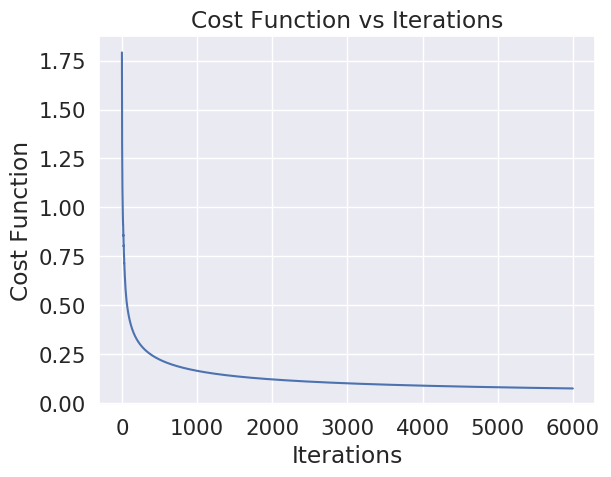

In [46]:
plt.plot(J_iteration)
plt.xlabel('Iterations')
plt.ylabel('Cost Function')
plt.title('Cost Function vs Iterations')
plt.savefig('Cost_Function_Multiclass.png')

Agora vamos avaliar os resultados para o conjunto de teste

0.8845892735913102
0.8845892735913102


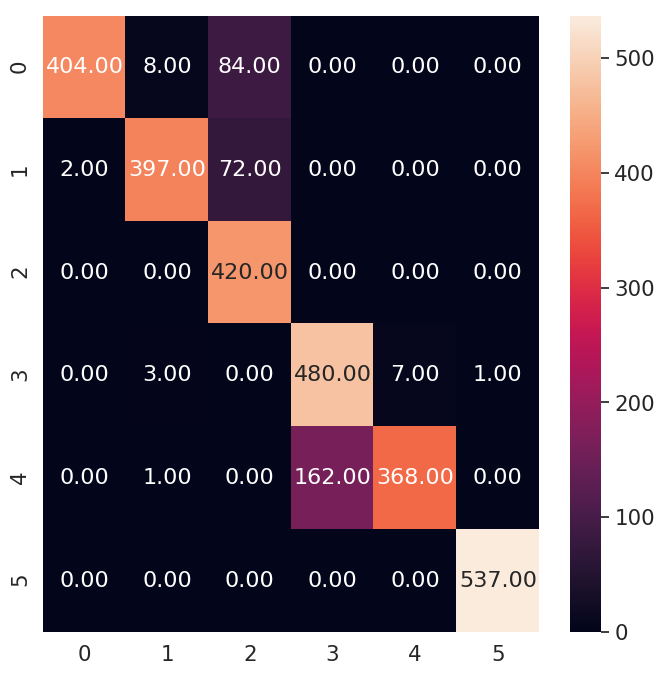

In [47]:
y_test_estimation = softmax_estimation(X_test_norm, w)
y_test_prediction = np.argmax(y_test_estimation, axis=1)+1

conf_matrix = confusion_matrix(Y_test, y_test_prediction)

fig, ax = plt.subplots(figsize=(8, 8))
df_cm = pd.DataFrame(conf_matrix, range(6), range(6))
#plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='.2f', ax=ax)# font size
plt.savefig('Confusion_matrix_Multiclass.png')

F1_score = f1_score(Y_test, y_test_prediction, average='micro')
#fp, tp, _ = roc_curve(Y_test, y_test_prediction)
print(F1_score)
print(accuracy_score(Y_test, y_test_prediction))

Para construir o algoritmo de K-vizinhos mais próximos se faz necessário calcular a distância entre o novo padrão de entrada e todas os outros padrões de treinamento. Com isso pode-se criar um dicionário ou um array bidimensional onde as linhas são os padrões de enrada e as k primeiras colunas são os atributos e a última coluna corresponde a saída. Assim ordena-se o vetor com relação aos seu valor de distância e pega-se os padrões que contém as k menores distâncias.

Neste ponto pode-se utilizar duas abordagens: (i) o voto majoritário, ou seja, calcular a quantidade de labels de cada label, entre o conjunto de k vizinhos mais próximos; (ii) Média ponderada pela distância: calcula-se a média dos rótulos em questão, ponderados pelo inverso da distância entre os rótulos. PORÉM NESSE PONTO TEMOS UM PROBLEMA: O RESULTADO NÃO SERÁ MAIS UM INTEIRO, ENTÃO COMO CALCULAR O VALOR DO RÓTULO??

In [ ]:
def KNN(X, y, new_x, k):
    dist1 = X - new_x
    dist_matrix = np.expand_dims(norm(dist1, axis=1), axis=0).T
    X_and_distance = np.concatenate((X, y), axis=1)
    X_and_distance = np.concatenate((X_and_distance, dist_matrix), axis = 1)
    X_and_distance_ordered = X_and_distance[X_and_distance[:, X_and_distance.shape[1]-1].argsort()]
    
    X_KNN = X_and_distance_ordered[0:k ,:]
    
    y_KNN = X_KNN[:, X_KNN.shape[1]-2]
    
    return mode(y_KNN)[0]

In [ ]:
X_train = X_train[:, 1:]
X_test = X_test[:, 1:]
K_values = [1, 3, 6, 10, 30, 60, 100]

Y_predicted = np.zeros((X_test.shape[0], len(K_values)))

iterations = 0
for k in K_values:
    print("K Value: " + str(k))
    for i in range(X_test.shape[0]):
        print("Test input: " + str(i))
        Y_predicted[i, iterations] = KNN(X_train, Y_train, X_test[i, :], k)
    iterations += 1

In [ ]:
conf_matrix_1 = confusion_matrix(Y_test, Y_predicted[:, 0])
F1_score_1 = f1_score(Y_test, Y_predicted[:, 0], average='micro')

fig, ax = plt.subplots(figsize=(8, 8))
df_cm = pd.DataFrame(conf_matrix_1, range(6), range(6))
#plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='.2f', ax=ax)# font size
plt.savefig('Confusion_matrix_Multi_Class_1.png')
print(F1_score_1)

conf_matrix_3 = confusion_matrix(Y_test, Y_predicted[:, 1])
F1_score_3 = f1_score(Y_test, Y_predicted[:, 1], average='micro')

fig, ax = plt.subplots(figsize=(8, 8))
df_cm = pd.DataFrame(conf_matrix_3, range(6), range(6))
#plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='.2f', ax=ax)# font size
plt.savefig('Confusion_matrix_Multi_Class_3.png')
print(F1_score_3)

conf_matrix_6 = confusion_matrix(Y_test, Y_predicted[:, 2])
F1_score_6 = f1_score(Y_test, Y_predicted[:, 2], average='micro')

fig, ax = plt.subplots(figsize=(8, 8))
df_cm = pd.DataFrame(conf_matrix_6, range(6), range(6))
#plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='.2f', ax=ax)# font size
plt.savefig('Confusion_matrix_Multi_Class_6.png')
print(F1_score_6)

conf_matrix_10 = confusion_matrix(Y_test, Y_predicted[:, 3])
F1_score_10 = f1_score(Y_test, Y_predicted[:, 3], average='micro')

fig, ax = plt.subplots(figsize=(8, 8))
df_cm = pd.DataFrame(conf_matrix_10, range(6), range(6))
#plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='.2f', ax=ax)# font size
plt.savefig('Confusion_matrix_Multi_Class_10.png')
print(F1_score_10)

conf_matrix_30 = confusion_matrix(Y_test, Y_predicted[:, 4])
F1_score_30 = f1_score(Y_test, Y_predicted[:, 4], average='micro')

fig, ax = plt.subplots(figsize=(8, 8))
df_cm = pd.DataFrame(conf_matrix_30, range(6), range(6))
#plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='.2f', ax=ax)# font size
plt.savefig('Confusion_matrix_Multi_Class_30.png')
print(F1_score_30)

conf_matrix_60 = confusion_matrix(Y_test, Y_predicted[:, 5])
F1_score_60 = f1_score(Y_test, Y_predicted[:, 5], average='micro')

fig, ax = plt.subplots(figsize=(8, 8))
df_cm = pd.DataFrame(conf_matrix_60, range(6), range(6))
#plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='.2f', ax=ax)# font size
plt.savefig('Confusion_matrix_Multi_Class_60.png')
print(F1_score_60)

conf_matrix_100 = confusion_matrix(Y_test, Y_predicted[:, 6])
F1_score_100 = f1_score(Y_test, Y_predicted[:, 6], average='micro')

fig, ax = plt.subplots(figsize=(8, 8))
df_cm = pd.DataFrame(conf_matrix_100, range(6), range(6))
#plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='.2f', ax=ax)# font size
plt.savefig('Confusion_matrix_Multi_Class_100.png')
print(F1_score_100)

In [ ]:
%matplotlib inline
plt.figure()
plt.plot(J_iteration)